In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print(device)

cuda


In [3]:
path = r'C:\Users\Siddhanth\Downloads\archive\pokemon'
os.path.exists(path)

True

Setting the Normalization parameters and hyperparameters

In [4]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64

Preprocessing

In [5]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

In [6]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [8]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

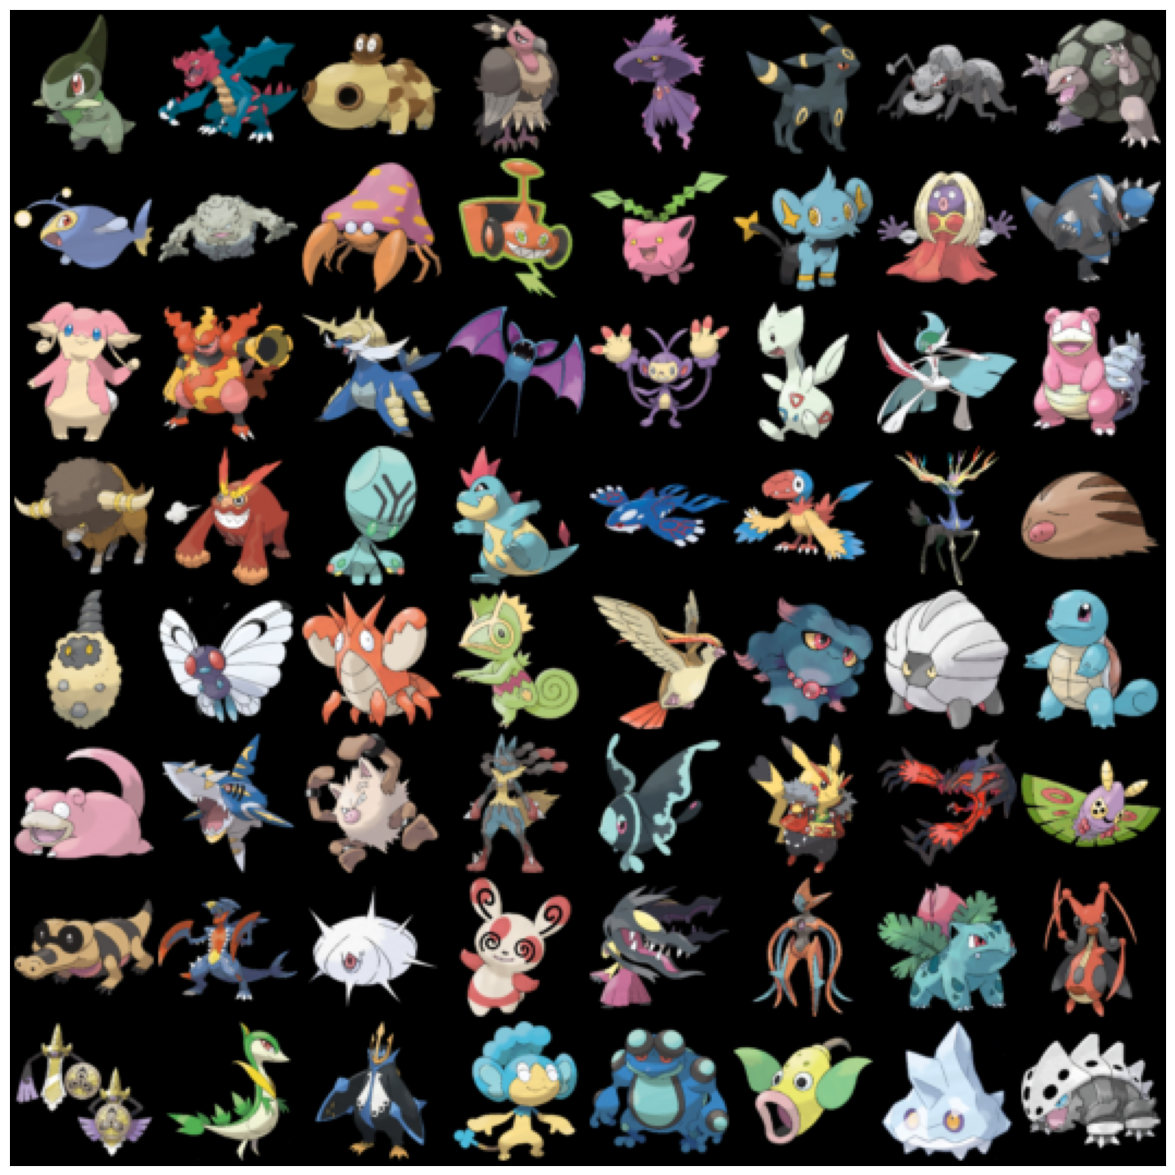

In [9]:
show_batch(dataloader)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
modelD = Discriminator()
modelD.to(device)
modelD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(modelD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [14]:
torch.backends.cudnn.benchmark = False 

Training Loop

In [15]:
import torchvision.utils as vutils

img_list = []
G_losses, D_losses = [], []
total = 0

for epoch in range(1000):
    g_loss = 0.0
    d_loss = 0.0
    D_x = 0.0
    D_G_z1 = 0.0
    D_G_z2 = 0.0
    
    for i, data in enumerate(dataloader, 0):
        
        modelD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = modelD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x += output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 += output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        modelG.zero_grad()
        label.fill_(real_label)
        output = modelD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 += output.mean().item()
        optimizerG.step()
        
        g_loss += errG.item()
        d_loss += errD.item()
        total += b_size
        
    avg_g_loss = g_loss / total
    G_losses.append(avg_g_loss)
    avg_d_loss = d_loss / total
    D_losses.append(avg_d_loss)
    
    avg_D_x = D_x / len(dataloader)
    avg_D_G_z1 = D_G_z1 / len(dataloader)
    avg_D_G_z2 = D_G_z2 / len(dataloader)
    
    print('Epoch: {} \tDiscriminator Loss: {:.6f} \tGenerator Loss: {:.6f} \tD(x): {:.6f} \tD(G(z)): {:.6f} / {:.6f}'.format(
        epoch + 1,
        avg_d_loss,
        avg_g_loss,
        avg_D_x,
        avg_D_G_z1,
        avg_D_G_z2
    ))
    
    with torch.no_grad():
        fake = modelG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(unnorm(fake, *norm), padding=2, normalize=True))
    
print('Finished Training')

c:\Users\Siddhanth\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1 	Discriminator Loss: 0.005832 	Generator Loss: 0.074363 	D(x): 0.914431 	D(G(z)): 0.185183 / 0.016442
Epoch: 2 	Discriminator Loss: 0.001217 	Generator Loss: 0.050583 	D(x): 0.953422 	D(G(z)): 0.083321 / 0.003066
Epoch: 3 	Discriminator Loss: 0.001228 	Generator Loss: 0.047852 	D(x): 0.934338 	D(G(z)): 0.108714 / 0.001349
Epoch: 4 	Discriminator Loss: 0.001243 	Generator Loss: 0.045378 	D(x): 0.933608 	D(G(z)): 0.135670 / 0.001890
Epoch: 5 	Discriminator Loss: 0.000799 	Generator Loss: 0.033951 	D(x): 0.901928 	D(G(z)): 0.080313 / 0.000675
Epoch: 6 	Discriminator Loss: 0.000351 	Generator Loss: 0.022575 	D(x): 0.953477 	D(G(z)): 0.067963 / 0.000697
Epoch: 7 	Discriminator Loss: 0.000192 	Generator Loss: 0.019924 	D(x): 0.970868 	D(G(z)): 0.046078 / 0.000568
Epoch: 8 	Discriminator Loss: 0.000183 	Generator Loss: 0.019560 	D(x): 0.968412 	D(G(z)): 0.046311 / 0.000495
Epoch: 9 	Discriminator Loss: 0.000209 	Generator Loss: 0.018839 	D(x): 0.949374 	D(G(z)): 0.048284 / 0.000676
E

In [16]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')

Loss:

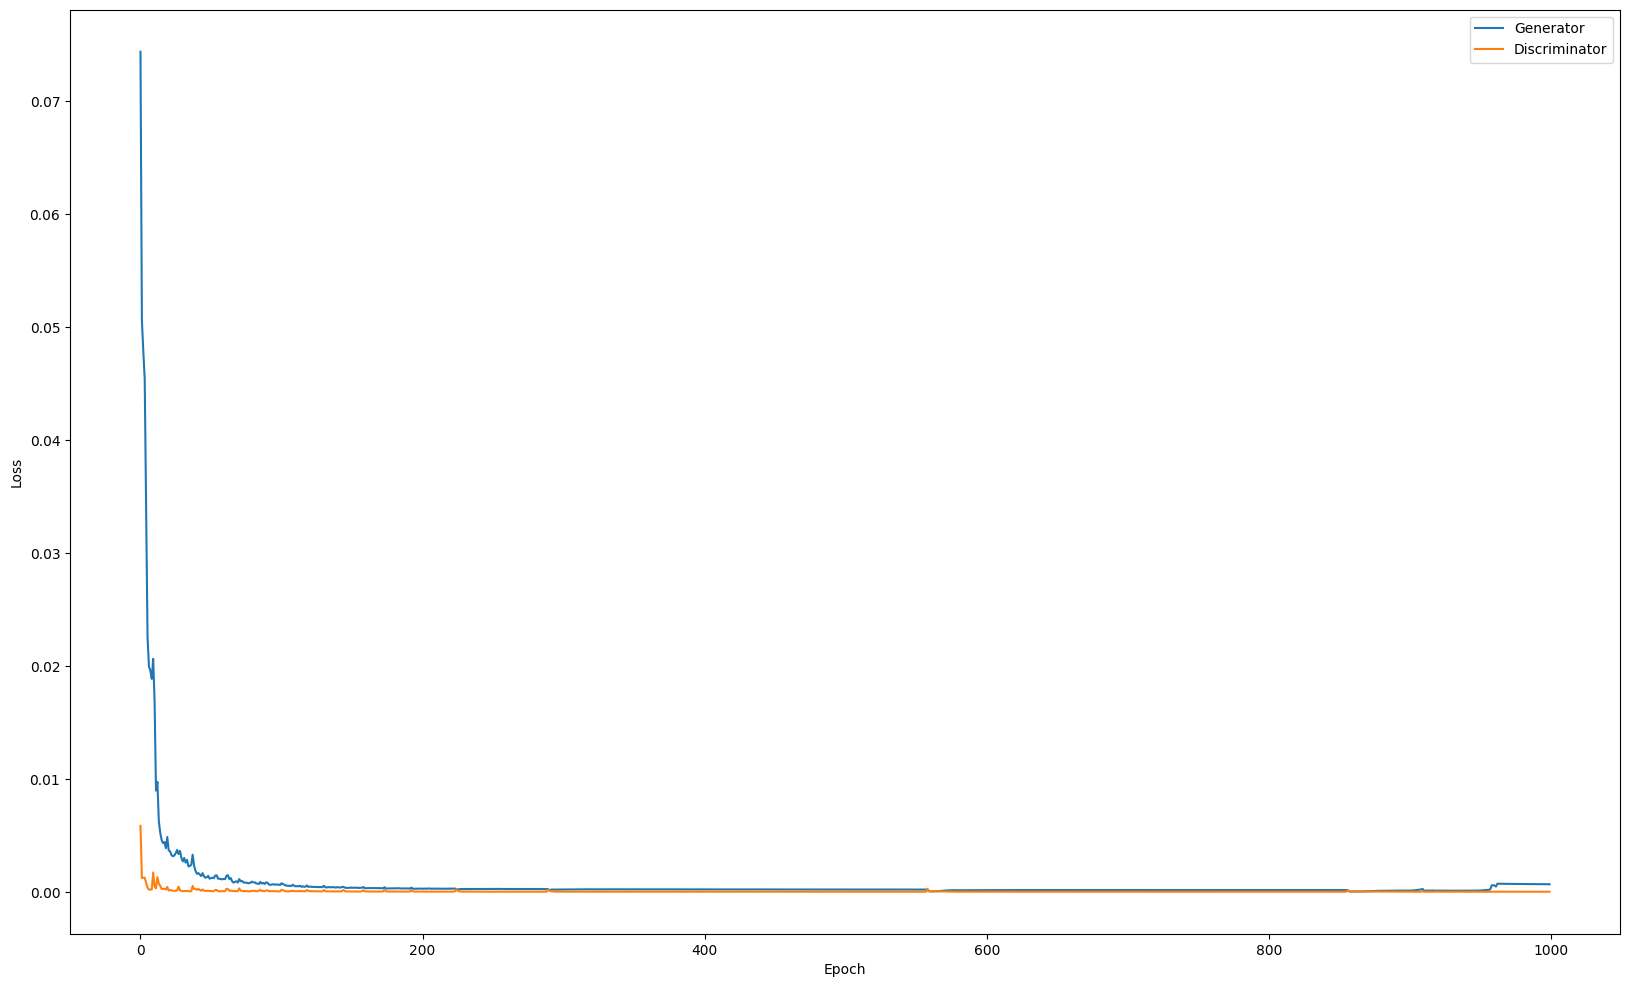

In [17]:
plt.figure(figsize=(20,12))
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()